In [29]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import umap
from sklearn.manifold import TSNE

In [3]:
# load env (which includes classification)
env_data_path = '../data/from-hari-v2/clean_combined_campaign_env_data.csv'
df_env = pd.read_csv(env_data_path)
df_env.shape

(524033, 48)

In [4]:
# load backbone features
emb_path = '../data/from-hari-v2/clean_combined_campaign_features.pth'
emb = torch.load(emb_path)
df_emb = pd.DataFrame(emb.numpy())
df_emb.shape

(524033, 384)

In [5]:
# merge df's 
df_merged = df_emb.merge(df_env, left_index=True, right_index=True)
df_merged.shape
# save 
save_dir = '/home/jko/ssl-cpi-analysis/data'
save_filename = 'cls_env_all_merged.parquet'
save_path = os.path.join(save_dir, save_filename)
df_merged.to_parquet(save_path, index=False)

In [45]:
# reload data to confirm
save_dir = '/home/jko/ssl-cpi-analysis/data'
save_filename = 'cls_env_all_merged.parquet'
save_path = os.path.join(save_dir, save_filename)
df_reload = pd.read_parquet(save_path)
df_reload.head()

0         1         2         3         4         5         6  \
0 -0.887133 -6.530055  3.476131 -5.162270  0.554749  1.124581  2.609353   
1 -2.354146 -4.088460  2.632596  3.802938 -1.102412  5.199676  3.841768   
2  0.430662 -2.768530 -1.170036 -4.344058 -2.350035  0.733127 -1.461737   
3 -1.020320 -3.822821 -0.308221 -5.112741 -2.422718 -0.710008 -2.398746   
4 -2.742858 -3.773942 -0.009707 -1.850386 -1.019795 -0.426605 -2.334836   

          7         8         9  ...  Altitude [m]  Pressure [hPa]  \
0  0.212265 -0.218764 -4.516725  ...   7617.879883      376.093658   
1  4.692372 -0.435102 -1.082343  ...   8834.772461      315.023621   
2 -3.898603 -1.505608 -9.590865  ...   8692.738867      321.706464   
3 -5.102628  0.606447 -8.622406  ...   9322.357031      292.931525   
4 -2.935339 -6.286791 -7.284194  ...   7011.962891      409.888617   

   Temperature [C]  Ice Water Content [g/m3]  PSD IWC [g/m3]  \
0       -34.019299                  0.041360        0.054664   
1       -46.836998                  0.019560        0.049062   
2       -42.729707                  0.054596        0.056262   
3       -48.294354                  0.027008        0.049581   
4       -32.159441                  0.063584        0.074550   

   concentration ratio  area ratio  mass ratio  Campaign  Perimeter [pixels]  
0             0.000046    0.001051    0.003035       ARM                 NaN  
1             0.000000    0.000000    0.000000       ARM                 NaN  
2             0.000977    0.021351    0.024678       ARM                 NaN  
3             0.000039    0.000372    0.001016       ARM                 NaN  
4             0.000017    0.000230    0.000886       ARM                 NaN  

[5 rows x 432 columns]

In [46]:
df_subset = df_merged.sample(1000)
emb_cols = list(range(384))
X = df_subset[emb_cols]
X_scaled = StandardScaler().fit_transform(X)

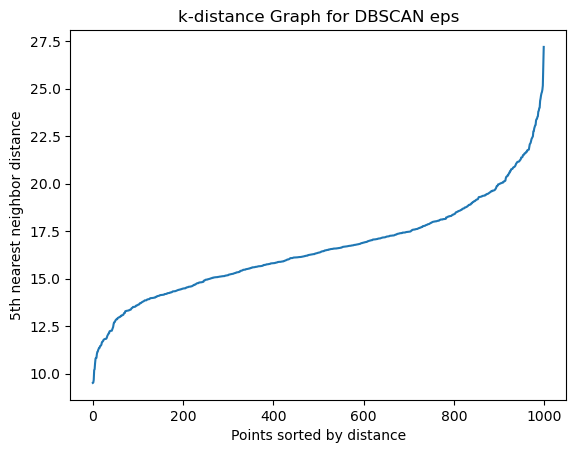

In [47]:
# cluster on subset of embeddings
k = 5  # usually set to min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, k-1])

plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}th nearest neighbor distance')
plt.title('k-distance Graph for DBSCAN eps')
plt.show()

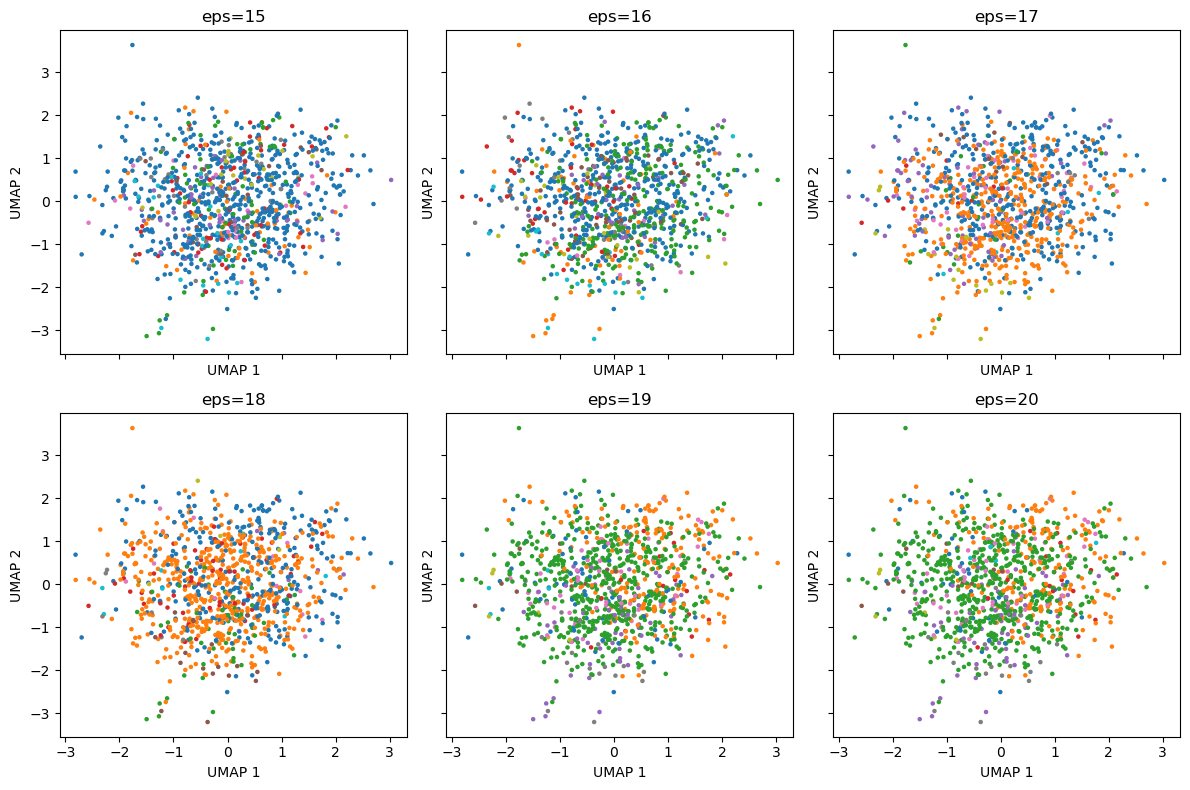

In [26]:
eps_values = list(range(15,21))
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, eps in enumerate(eps_values):
    clustering = DBSCAN(eps=eps, min_samples=5)
    labels = clustering.fit_predict(X_scaled)
    ax = axes[i]
    scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='tab10', s=5)
    ax.set_title(f'eps={eps}')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

# Hide any unused subplots if eps_values < 6
for j in range(len(eps_values), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [32]:
labels.unique()

array(['rimed', 'column', 'compact_irreg', 'agg', 'planar_polycrystal',
       'bullet', 'budding'], dtype=object)

In [14]:
# get a balanced subset
samples_per_class = 1000
dfs = []
for cls in ['compact_irreg', 'bullet', 'planar_polycrystal', 'agg', 'budding', 'column', 'rimed']:
    df_cls = df_merged[df_merged['Classification'] == cls].sample(n=samples_per_class, random_state=42)
    dfs.append(df_cls)
df_balanced = pd.concat(dfs).reset_index(drop=True)

In [ ]:
# plot n=100 from each class
emb_cols = list(range(384))
X = df_balanced[emb_cols]
X_scaled = StandardScaler().fit_transform(X)
n_components = 2

# UMAP
umap_model = umap.UMAP(n_components=n_components, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Map string labels to integers
labels = df_balanced['Classification']
classes = labels.unique()
class_to_int = {cls: i for i, cls in enumerate(classes)}
labels_int = labels.map(class_to_int)

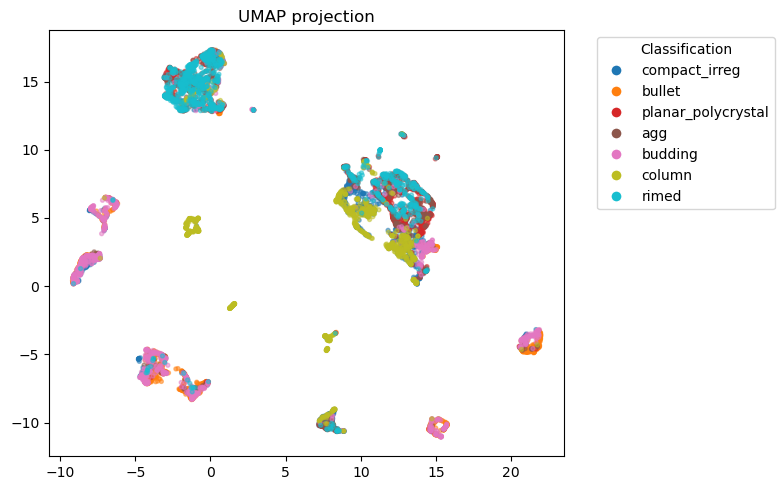

In [28]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=8, alpha=0.5, c=labels_int, cmap='tab10')
    
ax.set_title('UMAP projection')

# Get the color for each class from the scatter plot
colors = scatter.cmap(scatter.norm(list(class_to_int.values())))

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=cls,
               markerfacecolor=colors[class_to_int[cls]], markersize=8)
    for cls in classes
]
ax.legend(handles=handles, title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

/home/jko/miniconda3/envs/torch/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


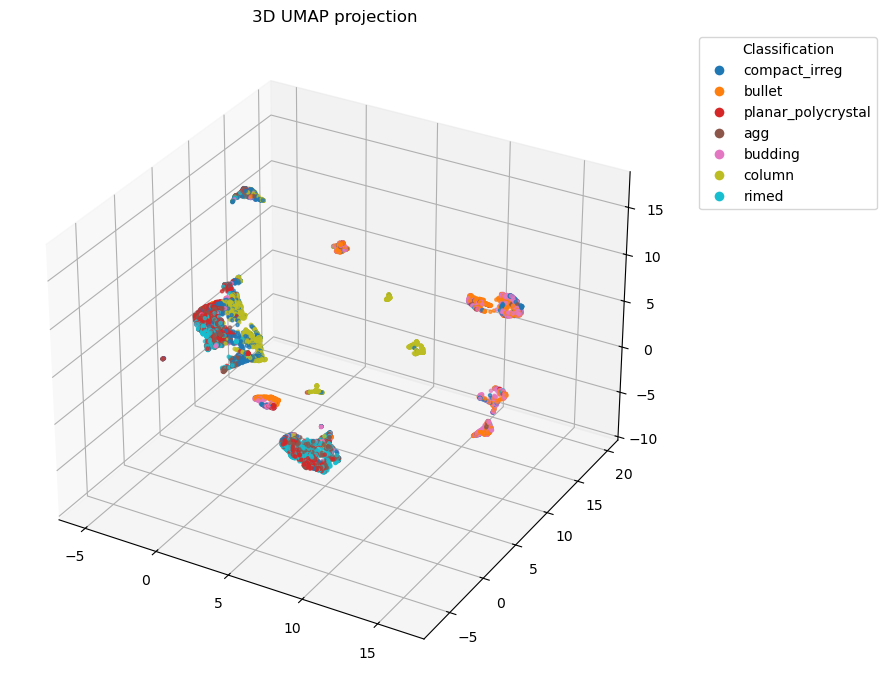

In [17]:
emb_cols = list(range(384))
X = df_balanced[emb_cols]
X_scaled = StandardScaler().fit_transform(X)
n_components = 3

# UMAP
umap_model = umap.UMAP(n_components=n_components, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Map string labels to integers
labels = df_balanced['Classification']
classes = labels.unique()
class_to_int = {cls: i for i, cls in enumerate(classes)}
labels_int = labels.map(class_to_int)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], s=5, alpha=0.7, c=labels_int, cmap='tab10')
ax.set_title('3D UMAP projection')

# Get the color for each class from the scatter plot
colors = scatter.cmap(scatter.norm(list(class_to_int.values())))

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=cls,
               markerfacecolor=colors[class_to_int[cls]], markersize=8)
    for cls in classes
]
ax.legend(handles=handles, title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Trying t-SNE

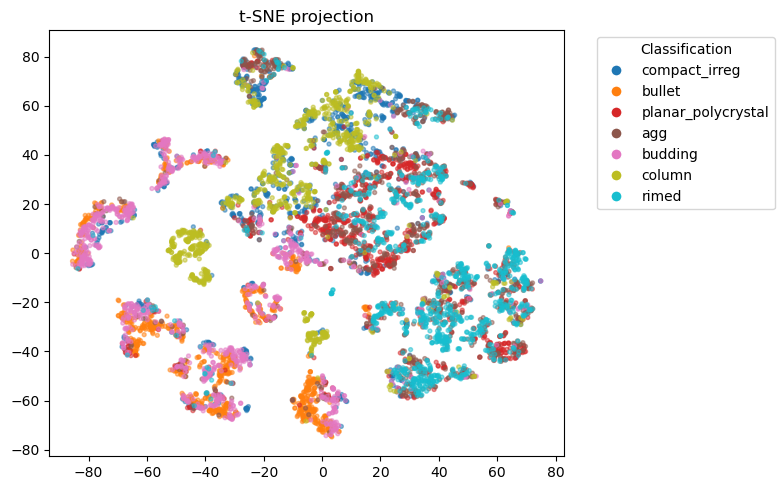

In [30]:
emb_cols = list(range(384))
X = df_balanced[emb_cols]
X_scaled = StandardScaler().fit_transform(X)
n_components = 2

# t-SNE
tsne_model = TSNE(n_components=n_components, random_state=42)
X_tsne = tsne_model.fit_transform(X_scaled)

# Map string labels to integers
labels = df_balanced['Classification']
classes = labels.unique()
class_to_int = {cls: i for i, cls in enumerate(classes)}
labels_int = labels.map(class_to_int)

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], s=8, alpha=0.5, c=labels_int, cmap='tab10')
ax.set_title('t-SNE projection')

# Get the color for each class from the scatter plot
colors = scatter.cmap(scatter.norm(list(class_to_int.values())))

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=cls,
               markerfacecolor=colors[class_to_int[cls]], markersize=8)
    for cls in classes
]
ax.legend(handles=handles, title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'  # or 'notebook_connected', or 'iframe'
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

emb_cols = list(range(384))
X = df_balanced[emb_cols]
X_scaled = StandardScaler().fit_transform(X)
n_components = 3

# t-SNE
tsne_model = TSNE(n_components=n_components, random_state=42)
X_tsne = tsne_model.fit_transform(X_scaled)

In [34]:
# Prepare DataFrame for Plotly
labels = df_balanced['Classification']
df_plot = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'z': X_tsne[:, 2],
    'Classification': labels
})

fig = px.scatter_3d(
    df_plot, x='x', y='y', z='z',
    color='Classification',
    symbol='Classification',
    title='Interactive 3D t-SNE projection (Plotly)',
    opacity=1.0
)
fig.update_traces(marker=dict(size=3))  # Set marker size to 3 (smaller)
fig.show()